# The Perceptron Pocket Algorithm

Many instances of data are linearily seperable, but only after removing *noise*; the following image is one such example. 

<img src="linear_noisy_data.png" alt="Drawing" style="width: 300px;"/>

Such data is actually encountered often: even though a linear classifier seems appropiate, the data may not be linearily seperable because of outliers or noise. Notably, we proved that the perceptron learning algorithm (PLA) will not converge whenever the training data is not linearily seperable. Thus, we must exclude the PLA from our toolkit in this instance. More specifically, we need solve the combinatorial optimization problem:

$$
\min_{\boldsymbol{w}\in\mathbb{R}^{d+1}}\frac{1}{N}\sum_{i=n}^{N}||\text{sign}(w^{T}\boldsymbol{x}_n) \neq y_n||.
$$

Note the in-sample error is given by:

$$
E_{\text{in}}(\boldsymbol{w}) = \frac{1}{N}\sum_{i=n}^{N}||\text{sign}(w^{T}\boldsymbol{x}_n) \neq y_n||.
$$

In general, determining the solution the above mentioned optimization problemn is NP-hard. Thus, we will only approximate the solution the minimization problem. Our algorithm is called the *pocket algorithm*. Essentially, the pocket algorithm keeps in its 'pocket' the best weight vector encountered up to iteration $t$ in PLA. At the end of the algorithm, the best weight vector will be reported as the final hypothesis. 

**The Pocket Algorithm**
1. Set the pocket weight vector $\hat{\boldsymbol{w}}$ to $\boldsymbol{w}(0)$ of PLA.
2. **for** $t=0,\dots,T-1$ **do**
 * $     $ $       $ Run PLA for one update to obtain $\boldsymbol{w}(t+1)$.
 * $     $ $       $ Evaluate $E_{\text{in}}(\boldsymbol{w}(t+1))$.
 * $     $ $       $ if $\boldsymbol{w}(t+1)$ is better than $\hat{\boldsymbol{w}}$ in terms of     $E_{\text{in}}(\boldsymbol{w}(t+1))$, set $\hat{\boldsymbol{w}}$ to $\boldsymbol{w}(t+1)$.
6. Return $\hat{\boldsymbol{w}}$

The original PLA only checks some of the examples using $\boldsymbol{w}(t)$ to identify $(\boldsymbol{x}(t), y(t))$ in each iteration, while the pocket algorithm needs an additional step that evaluates *all* examples using $\boldsymbol{w}(t+1)$ to get $E_{\text{in}}(\boldsymbol{w}(t+1))$. This additional step makes the pocket algorithm much slower that PLA. Nevertheless, it is a useful algorithm to know about. We will next implement the pocket algorithm to classify hand written images of digits in $\{1,5\}$ from the famous *mnist data set*. 

## MNIST Data Set

The MNIST data set consists of $70000$ images of hand written digits, $60000$ of which are typically used as labeled training examples, where the other $10000$ are used for testing your learning model on. The following picture represent a sample of some of the images.

<img src="MnistExamples.png" alt="Drawing" style="width: 500px;"/>


To access this data set, as well as view the data as an image, we will need the following packages:
 * MLDatasets [documentation](https://github.com/JuliaML/MLDatasets.jl)
 * Images, TestImages, ImageMagicIO [documentation](https://juliaimages.org/latest/)

In [2]:
using MLDatasets
using Images
using TestImages

train_x, train_y = MNIST.traindata()
test_x,  test_y  = MNIST.testdata();


The data structures train_x and test_x are stored as 3 dimensional tensors. 
 
 
 
<img src="order-3-tensor.png" alt="Drawing" style="width: 300px;"/>

In [3]:
# Show the dimensions of the train_x tensor.
size(train_x)

(28, 28, 60000)

In [4]:
# Verify the dimensions of the training vector. This should match the depth of out training 
# tensor. 
size(train_y)

(60000,)

In [5]:
# Verify the the shape of the elements in the tensor slices.
train_x[:,:,1]

28×28 Array{N0f8,2} with eltype Normed{UInt8,8}:
 0.0  0.0  0.0  0.0  0.0  0.0    0.0    …  0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.216  0.533  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0    …  0.0    0.675  0.992  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.071  0.886  0.992  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.671  0.992  0.992  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.118     0.859  0.992  0.831  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.141     0.992  0.992  0.529  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.369  …  0.992  0.992  0.518  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.604     0.992  0.957  0.063  0.0  0.0  0.0
 0.0  0.0  0.0 

Each image in the is comprised of a $28\times 28$ grey scaled grid of pixel values. These values are floating point numbers in the interval $(0,1)$, where darker pixels will have values closer to $1$ and lighter pixels will have values closer to $0$. The following image represents one such example. 
<img src="MNIST-Matrix.png" alt="Drawing" style="width: 600px;"/>

In [6]:
# What are the entries in each of these 28x28 matrices??
train_x[:,:,1]

28×28 Array{N0f8,2} with eltype Normed{UInt8,8}:
 0.0  0.0  0.0  0.0  0.0  0.0    0.0    …  0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.216  0.533  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0    …  0.0    0.675  0.992  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.071  0.886  0.992  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.671  0.992  0.992  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.118     0.859  0.992  0.831  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.141     0.992  0.992  0.529  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.369  …  0.992  0.992  0.518  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.604     0.992  0.957  0.063  0.0  0.0  0.0
 0.0  0.0  0.0 

In [7]:
# Check the label of the above matrix. 
train_y[1]

5

┌ Info: Recompiling stale cache file /Users/randydavila/.julia/compiled/v1.0/QuartzImageIO/n8vDP.ji for QuartzImageIO [dca85d43-d64c-5e67-8c65-017450d5d020]
└ @ Base loading.jl:1190


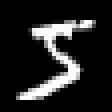

In [8]:
# View the image
colorview(Gray, train_x[:,:,1]')

In [9]:
# Use the pocket algorithm to classify images of numbers in the set {1,5}. Note that this is a
# binary classification problem, even though the input vectors have dimension much larger than
# we have seen before. 

# Reduce the dimension of the input data
pocket_train_x = []
pocket_train_y = []
for i = 1:60000
    if train_y[i] == 1 || train_y[i] == 5
        push!(pocket_train_x, reshape(train_x[:,:,i], 784))
        push!(pocket_train_y, train_y[i] == 1 ? 1 : -1)
    end
end

# Handy-dandy sign function
function sign(w, x)
    x = push!(copy(x), 1.0)
    return w'x > 0 ? 1 : -1
end

# Define the in-sample error
function errors(w)
    return sum([sign(w, pocket_train_x[i])!= pocket_train_y[i] ? 1 : 0 
            for i = 1:size(pocket_train_x)[1]])/size(pocket_train_x)[1]
end

errors (generic function with 1 method)

In [10]:
# Define the pocket algorithm on T iterations
function pocket_algorithm(T)
    w = randn(785)
    w_hat = copy(w)
    for i = 1:T
        for j = 1:size(pocket_train_x)[1]
            if sign(w, pocket_train_x[j]) != pocket_train_y[j]
                w += pocket_train_y[j]*push!(copy(pocket_train_x[j]),1.0)
            end
        end
        if errors(w) < errors(w_hat)
                    w_hat = copy(w)
        end
    end
    return w_hat
end

pocket_algorithm (generic function with 1 method)

In [11]:
# Let's try it!
#w = rand(785)
w_new = pocket_algorithm(500);

In [12]:
indicies = []
for i in 1:size(test_y)[1]
    if test_y[i] == 1 || test_y[i] == 5
        push!(indicies, (i, test_y[i]))
    end
end        

In [15]:
function check_value(i)
    println("Predicted value:", 
        sign(w_new, reshape(test_x[:,:,indicies[i][1]], 784)) == 1 ? 1 : 5, "\n")
    println("Labeled value:", test_y[indicies[i][1]], "\n")
    println("Image:")
    colorview(Gray, test_x[:,:,indicies[i][1]]')
end

check_value (generic function with 1 method)

Predicted value:5

Labeled value:5

Image:


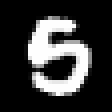

In [18]:
check_value(100)

Predicted value:7

Labeled value:7

Image:


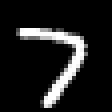

In [53]:
check_value(2)

Predicted value:7

Labeled value:3

Image:


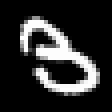

In [54]:
check_value(3)

Predicted value:7

Labeled value:7

Image:


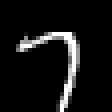

In [49]:
check_value(4)

Predicted value:7

Labeled value:3

Image:


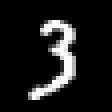

In [50]:
check_value(323)

Predicted value:5

Labeled value:5

Image:


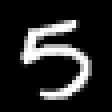

In [21]:
check_value(129)

Predicted value:5

Labeled value:5

Image:


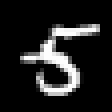

In [24]:
check_value(1700)

Predicted value:1

Labeled value:1

Image:


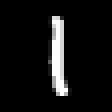

In [29]:
check_value(1200)